### Functions & define

In [6]:
import numpy as np

def load_session_data(subject, date):
    """Load all data for a given subject and date"""
    import sys
    sys.path.append(r'D:\Neural-Pipeline\source')
    from analysis_utils.NeuralDataLoader import NeuralDataLoader, Dots3DMPConfig
    
    # Load session
    loader = NeuralDataLoader()
    loader.load_session(subject, date)
    config = Dots3DMPConfig(subject)

    # spike data (unit, trial, time)
    stimOn_spikes = loader.get_spike_data(alignment='stimOn', good_units_only=True, good_trials_only=True)
    saccOnset_spikes = loader.get_spike_data(alignment='saccOnset', good_units_only=True, good_trials_only=True)
    postTargHold_spikes = loader.get_spike_data(alignment='postTargHold', good_units_only=True, good_trials_only=True)
    tuning_spikes = loader.get_tuning_data(good_units_only=True, good_trials_only=True)

    # behavioral data
    behavior_dots3DMP = loader.get_behavioral_data(task='dots3DMP', good_trials_only=True)
    behavior_tuning = loader.get_behavioral_data(task='tuning', good_trials_only=True)
    behavior_converted = config.convert_behavioral_data(behavior_dots3DMP, task='dots3DMP')
    behavior_tuning_converted = config.convert_behavioral_data(behavior_tuning, task='tuning')

    # Unit Info
    unit_info = loader.get_unit_info(good_units_only=True)
    MST_units = loader.get_units_by_area(unit_info, area_name='MST')
    VPS_units = loader.get_units_by_area(unit_info, area_name='VPS')
    dual_units = loader.get_units_by_area(unit_info, area_name='dual')

    # Time Info
    time_info = config.get_time_Info('dots3DMP')
    time_info_tuning = config.get_time_Info('tuning')
    time_axes_dots3DMP = config.get_time_axes('dots3DMP')

    # Prepare data
    spikes_data = {
        'stimOn': stimOn_spikes,
        'saccOnset': saccOnset_spikes,
        'postTargHold': postTargHold_spikes
    }
    
    units_data = {
        'MST': MST_units,
        'VPS': VPS_units,
        'dual': dual_units
    }
    
    return {
        'loader': loader,
        'config': config,
        'spikes_data': spikes_data,
        'behavior_converted': behavior_converted,
        'behavior_tuning_converted': behavior_tuning_converted,
        'unit_info': unit_info,
        'units_data': units_data,
        'time_axes_dots3DMP': time_axes_dots3DMP,
        'time_info': time_info,
        'time_info_tuning': time_info_tuning
    }



In [7]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, ks_2samp, mannwhitneyu, ttest_ind
from scipy.signal import find_peaks
from scipy.stats import gaussian_kde

def plot_2d_scatter_with_marginals(pop1_x, pop1_y, pop2_x, pop2_y, 
                                   xlabel='X Variable', ylabel='Y Variable', 
                                   title='2D Scatter Plot with Marginals',
                                   legend_labels=['Population 1', 'Population 2'],
                                   colors=['#2E86AB', '#A23B72'],
                                   figsize=(10, 10), 
                                   alpha=0.7, 
                                   hist_alpha=0.5,
                                   point_size=50,
                                   show_correlation=True,
                                   kde=True,
                                   bins=20,
                                   highlight_peaks=True,  # NEW
                                   statistical_tests=True):  # NEW
    """
    Create a 2D scatter plot with marginal histograms for two populations.
    
    NEW PARAMETERS:
    ---------------
    highlight_peaks : bool
        Whether to highlight histogram peaks with vertical lines and annotations
    statistical_tests : bool
        Whether to perform and display statistical tests between populations
    """
    
    # Combine data into DataFrame
    df = pd.DataFrame({
        'x': np.concatenate([pop1_x, pop2_x]),
        'y': np.concatenate([pop1_y, pop2_y]),
        'population': [legend_labels[0]] * len(pop1_x) + [legend_labels[1]] * len(pop2_x)
    })
    
    # Set custom colors
    sns.set_palette(colors)
    
    # Create JointGrid
    g = sns.JointGrid(data=df, x='x', y='y', hue='population', 
                      height=figsize[0], ratio=5)
    
    # Main scatter plot
    g.plot_joint(sns.scatterplot, alpha=alpha, s=point_size, 
                 edgecolor='white', linewidth=0.5)
    
    # Handle custom bins
    if bins == 'custom':
        custom_bins = np.arange(0, 1.1, 0.1)
        bins_to_use = custom_bins
    else:
        bins_to_use = bins
    
    # Marginal histograms with custom alpha and bins
    g.plot_marginals(sns.histplot, alpha=hist_alpha, kde=kde, stat='density', bins=bins_to_use)
    
    # HIGHLIGHT PEAKS AND STATISTICAL TESTS
    if highlight_peaks or statistical_tests:
        # Separate populations
        pop1_x_arr = np.array(pop1_x)
        pop1_y_arr = np.array(pop1_y)
        pop2_x_arr = np.array(pop2_x)
        pop2_y_arr = np.array(pop2_y)
        
        # Find peaks for X dimension (top marginal)
        if highlight_peaks:
            x_range = np.linspace(min(df['x']), max(df['x']), 100)
            
            # KDE for population 1 X
            if len(pop1_x_arr) > 1:
                kde1_x = gaussian_kde(pop1_x_arr)
                density1_x = kde1_x(x_range)
                peaks1_x, _ = find_peaks(density1_x, height=0.1)
                
                for peak_idx in peaks1_x:
                    peak_x = x_range[peak_idx]
                    g.ax_marg_x.axvline(peak_x, color=colors[0], linestyle='--', alpha=0.8, linewidth=2)
                    g.ax_marg_x.annotate(f'{peak_x:.2f}', 
                                        xy=(peak_x, density1_x[peak_idx]), 
                                        xytext=(5, 5), textcoords='offset points',
                                        fontsize=10, color=colors[0], weight='bold')
            
            # KDE for population 2 X
            if len(pop2_x_arr) > 1:
                kde2_x = gaussian_kde(pop2_x_arr)
                density2_x = kde2_x(x_range)
                peaks2_x, _ = find_peaks(density2_x, height=0.1)
                
                for peak_idx in peaks2_x:
                    peak_x = x_range[peak_idx]
                    g.ax_marg_x.axvline(peak_x, color=colors[1], linestyle='--', alpha=0.8, linewidth=2)
                    g.ax_marg_x.annotate(f'{peak_x:.2f}', 
                                        xy=(peak_x, density2_x[peak_idx]), 
                                        xytext=(5, -15), textcoords='offset points',
                                        fontsize=10, color=colors[1], weight='bold')
        
            # Find peaks for Y dimension (right marginal)
            y_range = np.linspace(min(df['y']), max(df['y']), 100)
            
            # KDE for population 1 Y
            if len(pop1_y_arr) > 1:
                kde1_y = gaussian_kde(pop1_y_arr)
                density1_y = kde1_y(y_range)
                peaks1_y, _ = find_peaks(density1_y, height=0.1)
                
                for peak_idx in peaks1_y:
                    peak_y = y_range[peak_idx]
                    g.ax_marg_y.axhline(peak_y, color=colors[0], linestyle='--', alpha=0.8, linewidth=2)
                    g.ax_marg_y.annotate(f'{peak_y:.2f}', 
                                        xy=(density1_y[peak_idx], peak_y), 
                                        xytext=(5, 5), textcoords='offset points',
                                        fontsize=10, color=colors[0], weight='bold', rotation=90)
            
            # KDE for population 2 Y
            if len(pop2_y_arr) > 1:
                kde2_y = gaussian_kde(pop2_y_arr)
                density2_y = kde2_y(y_range)
                peaks2_y, _ = find_peaks(density2_y, height=0.1)
                
                for peak_idx in peaks2_y:
                    peak_y = y_range[peak_idx]
                    g.ax_marg_y.axhline(peak_y, color=colors[1], linestyle='--', alpha=0.8, linewidth=2)
                    g.ax_marg_y.annotate(f'{peak_y:.2f}', 
                                        xy=(density2_y[peak_idx], peak_y), 
                                        xytext=(-15, 5), textcoords='offset points',
                                        fontsize=10, color=colors[1], weight='bold', rotation=90)
    
    # Customize labels and title
    g.ax_joint.set_xlabel(xlabel, fontsize=14)
    g.ax_joint.set_ylabel(ylabel, fontsize=14)
    g.fig.suptitle(title, fontsize=16, y=0.98)
    
    # Add grid
    g.ax_joint.grid(True, alpha=0.3)
    
    # Set custom axis ticks
    custom_ticks = np.arange(-0.4, 0.5, 0.1)
    g.ax_joint.set_xticks(custom_ticks)
    g.ax_joint.set_yticks(custom_ticks)
    g.ax_marg_x.set_xticks(custom_ticks)
    g.ax_marg_y.set_yticks(custom_ticks)
    
    # Set axis limits
    g.ax_joint.set_xlim(-0.4, 0.4)
    g.ax_joint.set_ylim(-0.4, 0.4)
    
    # STATISTICAL TESTS
    if statistical_tests:
        print(f"\n{'='*50}")
        print(f"STATISTICAL COMPARISONS BETWEEN POPULATIONS")
        print(f"{'='*50}")
        
        # X dimension tests
        print(f"\nX Dimension ({xlabel}):")
        print(f"-" * 30)
        
        # Descriptive statistics
        print(f"{legend_labels[0]}: mean={np.mean(pop1_x_arr):.3f}, std={np.std(pop1_x_arr):.3f}, n={len(pop1_x_arr)}")
        print(f"{legend_labels[1]}: mean={np.mean(pop2_x_arr):.3f}, std={np.std(pop2_x_arr):.3f}, n={len(pop2_x_arr)}")
        
        # Statistical tests for X
        if len(pop1_x_arr) > 2 and len(pop2_x_arr) > 2:
            # T-test
            t_stat_x, t_p_x = ttest_ind(pop1_x_arr, pop2_x_arr)
            print(f"T-test: t={t_stat_x:.3f}, p={t_p_x:.3f}")
            
            # Mann-Whitney U test (non-parametric)
            u_stat_x, u_p_x = mannwhitneyu(pop1_x_arr, pop2_x_arr, alternative='two-sided')
            print(f"Mann-Whitney U: U={u_stat_x:.1f}, p={u_p_x:.3f}")
            
            # Kolmogorov-Smirnov test
            ks_stat_x, ks_p_x = ks_2samp(pop1_x_arr, pop2_x_arr)
            print(f"KS test: D={ks_stat_x:.3f}, p={ks_p_x:.3f}")
        
        # Y dimension tests
        print(f"\nY Dimension ({ylabel}):")
        print(f"-" * 30)
        
        # Descriptive statistics
        print(f"{legend_labels[0]}: mean={np.mean(pop1_y_arr):.3f}, std={np.std(pop1_y_arr):.3f}, n={len(pop1_y_arr)}")
        print(f"{legend_labels[1]}: mean={np.mean(pop2_y_arr):.3f}, std={np.std(pop2_y_arr):.3f}, n={len(pop2_y_arr)}")
        
        # Statistical tests for Y
        if len(pop1_y_arr) > 2 and len(pop2_y_arr) > 2:
            # T-test
            t_stat_y, t_p_y = ttest_ind(pop1_y_arr, pop2_y_arr)
            print(f"T-test: t={t_stat_y:.3f}, p={t_p_y:.3f}")
            
            # Mann-Whitney U test (non-parametric)
            u_stat_y, u_p_y = mannwhitneyu(pop1_y_arr, pop2_y_arr, alternative='two-sided')
            print(f"Mann-Whitney U: U={u_stat_y:.1f}, p={u_p_y:.3f}")
            
            # Kolmogorov-Smirnov test
            ks_stat_y, ks_p_y = ks_2samp(pop1_y_arr, pop2_y_arr)
            print(f"KS test: D={ks_stat_y:.3f}, p={ks_p_y:.3f}")
        
        # Interpretation
        print(f"\nInterpretation (α = 0.05):")
        print(f"-" * 30)
        if len(pop1_x_arr) > 2 and len(pop2_x_arr) > 2:
            print(f"X dimension: {'Significantly different' if t_p_x < 0.05 else 'Not significantly different'}")
        if len(pop1_y_arr) > 2 and len(pop2_y_arr) > 2:
            print(f"Y dimension: {'Significantly different' if t_p_y < 0.05 else 'Not significantly different'}")
    
    # Print correlation statistics if requested
    if show_correlation:
        print(f"\n{'='*30}")
        print(f"CORRELATION STATISTICS")
        print(f"{'='*30}")
        
        # Overall correlation
        r_overall, p_overall = pearsonr(df['x'], df['y'])
        print(f"Overall: r = {r_overall:.3f}, p = {p_overall:.3f}")
        
        # Per population correlation
        for i, label in enumerate(legend_labels):
            pop_data = df[df['population'] == label]
            if len(pop_data) > 2:
                r, p = pearsonr(pop_data['x'], pop_data['y'])
                print(f"{label}: r = {r:.3f}, p = {p:.3f}")
    
    plt.tight_layout()
    return g
    

In [8]:
# Define heading groups
heading_groups = {
    '10°': 7,    # Most extreme headings
    '3.9°': 6,     # Medium-high headings  
    '1.5°': 5,   # Medium-low headings
    '0°': 4,         # Zero heading (ambiguous)
    '-1.5°': 3,   # Medium-low headings
    '-3.9°': 2,     # Medium-high headings
    '-10°': 1,    # Most extreme headings

}
# Define session dates to analyze
dates = ["20250602", "20250702","20250523", "20250710"]   

# Defualt function to create file path
def get_filepath(date, area, alignment, target):
    return f"D:\\Neural-Pipeline\\results\\analysis_population\\decoders\\zarya_{date}_{area}_{target}_{alignment}_train_mod1_coh1_test_mod1_coh1_cv_results.npy"

In [9]:
def extract_decoding_data_for_scatter(date="20250602", area="dual", target="stimulus", data_dict = load_session_data("zarya", "20250602"),
                                      n_bins_forward=50, n_bins_backward=10, heading_groups=heading_groups):
    """Extract decoding probabilities for scatter plot analysis."""
    
    stim_filepath = get_filepath(date, area, "stimOn", target)
    choice_filepath = get_filepath(date, area, "saccOnset", target)
    
    # Load time axes
    time_axes_stim = data_dict['time_axes_dots3DMP']['stimOn']
    time_axes_choice = data_dict['time_axes_dots3DMP']['saccOnset']
    
    # Find time bin indices
    
    stim_zero_idx = np.argmin(np.abs(time_axes_stim))
    stim_bin_indices = list(range(stim_zero_idx, min(stim_zero_idx + n_bins_forward, len(time_axes_stim))))
    baseline_bin_indices = list(range(0, n_bins_backward))  # Baseline bins before stimulus onset
    choice_zero_idx = np.argmin(np.abs(time_axes_choice))
    choice_bin_indices = list(range(max(0, choice_zero_idx - n_bins_backward), (choice_zero_idx + n_bins_forward)))
    print(stim_bin_indices, choice_bin_indices)
    
    print(f"Stimulus time bins: {stim_bin_indices}")
    print(f"Choice time bins: {choice_bin_indices}")
    
    try:
        results_stim = np.load(stim_filepath, allow_pickle=True).item()
        trial_results_stim = results_stim['trial_results']
        
        results_choice = np.load(choice_filepath, allow_pickle=True).item()
        trial_results_choice = results_choice['trial_results']
        
        # Initialize storage
        combined_data_dict = {}
        
        # Process stimulus data first
        print(f"\n=== PROCESSING STIMULUS DATA ===")
        previous_time_bin = None
        cv_index = 0
        
        for cv_data in trial_results_stim:
            time_bin = cv_data['time']
            
            if time_bin != previous_time_bin:
                cv_index = 0
            else:
                cv_index += 1
            previous_time_bin = time_bin
            
            # Check if this time bin is in our desired range for stimulus
            if time_bin in stim_bin_indices:
                
                # Extract all data from this CV fold
                behavior = cv_data['test_behavior']
                headings = behavior['headingInd']
                choices = behavior['choice']
                pdws = behavior['PDW']
                corrects = behavior['correct']
                y_probas = cv_data['y_proba']
                
                # Store each trial
                for trial_idx, heading in enumerate(headings):
                    key = (cv_index, trial_idx)
                    
                    if key not in combined_data_dict:
                        combined_data_dict[key] = {
                            'heading': heading,
                            'choice': choices[trial_idx],
                            'pdw': pdws[trial_idx],
                            'correct': corrects[trial_idx],
                            'trial_idx': trial_idx,
                            'cv_index': cv_index,
                            'stim_probas': [],
                            'choice_probas': [],
                            'stim_time_bins': [],
                            'choice_time_bins': [],
                            'baseline_probas': [],
                            'baseline_time_bins': []
                        }
                    
                    # Append stimulus data for this time bin
                    combined_data_dict[key]['stim_probas'].append(y_probas[trial_idx])
                    combined_data_dict[key]['stim_time_bins'].append(time_bin)

            elif time_bin in baseline_bin_indices:

                # Extract all data from this CV fold
                behavior = cv_data['test_behavior']
                headings = behavior['headingInd']
                choices = behavior['choice']
                pdws = behavior['PDW']
                corrects = behavior['correct']
                y_probas = cv_data['y_proba']
                
                # Store each trial
                for trial_idx, heading in enumerate(headings):
                    key = (cv_index, trial_idx)
                    
                    if key not in combined_data_dict:
                        combined_data_dict[key] = {
                            'heading': heading,
                            'choice': choices[trial_idx],
                            'pdw': pdws[trial_idx],
                            'correct': corrects[trial_idx],
                            'trial_idx': trial_idx,
                            'cv_index': cv_index,
                            'stim_probas': [],
                            'choice_probas': [],
                            'stim_time_bins': [],
                            'choice_time_bins': [],
                            'baseline_probas': [],
                            'baseline_time_bins': []
                        }

                    # Append baseline data for this time bin
                    combined_data_dict[key]['baseline_probas'].append(y_probas[trial_idx])
                    combined_data_dict[key]['baseline_time_bins'].append(time_bin)

        # Process choice data second
        print(f"\n=== PROCESSING CHOICE DATA ===")
        previous_time_bin = None
        cv_index = 0
        
        for cv_data in trial_results_choice:
            time_bin = cv_data['time']
            
            if time_bin != previous_time_bin:
                cv_index = 0
            else:
                cv_index += 1
            previous_time_bin = time_bin
            
            # Check if this time bin is in our desired range for choice
            if time_bin in choice_bin_indices:
                
                # Extract all data from this CV fold
                behavior = cv_data['test_behavior']
                headings = behavior['headingInd']
                y_probas = cv_data['y_proba']
                
                # Store each trial
                for trial_idx, heading in enumerate(headings):
                    key = (cv_index, trial_idx)
                    
                    # Check if this key exists from stimulus processing
                    if key in combined_data_dict:
                        # Append choice data for this time bin
                        combined_data_dict[key]['choice_probas'].append(y_probas[trial_idx])
                        combined_data_dict[key]['choice_time_bins'].append(time_bin)
                    else:
                        print(f"Warning: Key {key} not found in stimulus data for choice processing")

        # Now average probabilities for each trial
        print(f"\n=== AVERAGING PROBABILITIES FOR EACH TRIAL ===")
        final_data = []
        
        for key, data in combined_data_dict.items():
            if len(data['stim_probas']) > 0 and len(data['choice_probas']) > 0:
                # Average across time bins for this trial
                avg_stim_proba = np.mean(data['stim_probas'])
                avg_choice_proba = np.mean(data['choice_probas'])
                ave_baseline_proba = np.mean(data['baseline_probas']) 
                
                final_entry = {
                    'cv_index': data['cv_index'],
                    'trial_idx': data['trial_idx'],
                    'heading': data['heading'],
                    'choice': data['choice'],
                    'pdw': data['pdw'],
                    'correct': data['correct'],
                    'y_proba_stimulus': avg_stim_proba,
                    'y_proba_choice': avg_choice_proba,
                    'y_proba_baseline': ave_baseline_proba,
                    "y_proba_stimulus_norm": avg_stim_proba - ave_baseline_proba,
                    "y_proba_choice_norm": avg_choice_proba - ave_baseline_proba,
                    # Keep raw data for debugging
                    'stim_probas_raw': data['stim_probas'],
                    'choice_probas_raw': data['choice_probas'],
                    'baseline_probas_raw': data['baseline_probas'],  
                    'stim_time_bins': data['stim_time_bins'],
                    'choice_time_bins': data['choice_time_bins'],
                    'baseline_timebins': data['baseline_time_bins'],
                    
                }
                
                final_data.append(final_entry)
                
                print(f"Trial {key}: stim_avg={avg_stim_proba:.3f} (from {len(data['stim_probas'])} bins), "
                      f"choice_avg={avg_choice_proba:.3f} (from {len(data['choice_probas'])} bins)")

        print(f"\n=== ORGANIZING BY HEADING GROUPS ===")
        scatter_data = {}
        
        # Skip 0° heading for stimulus target
        current_heading_groups = heading_groups.copy()
        if target == 'stimulus':
            if '0°' in current_heading_groups:
                del current_heading_groups['0°']
            print("Skipping 0° heading for stimulus target")
        
        for group_name, group_heading in current_heading_groups.items():
            scatter_data[group_name] = []
            
            for entry in final_data:
                # Fix: Compare integer to integer (not integer to list)
                if entry['heading'] == group_heading:  # Changed from 'in' to '=='
                    scatter_data[group_name].append(entry)

        # Print summary
        print(f"\nFinal data summary:")
        total_trials = 0
        for group_name, data in scatter_data.items():
            print(f"  {group_name}: {len(data)} trials")
            total_trials += len(data)
        print(f"  Total: {total_trials} unique behavioral trials")
        
        return scatter_data
    
    except Exception as e:
        print(f"Error processing data: {e}")
        return None

Loaded dots3DMP data: zarya20250602dots3DMP_processed.npz
Loaded dots3DMPtuning data: zarya20250602dots3DMPtuning_processed.npz
Loaded dots3DMP configuration for subject: zarya


In [10]:
all_sessions_data['20250602']

NameError: name 'all_sessions_data' is not defined

In [ ]:
# Define session dates to analyze
dates = ["20250602", "20250702", "20250523", "20250710"]   

# Initialize storage for all sessions
all_sessions_data = {}

# Loop through each date
for date in dates:
    print(f"\n{'='*50}")
    print(f"Processing session: {date}")
    print(f"{'='*50}")
    
    try:
        # Load session data for this date
        data_dict = load_session_data("zarya", date)
        
        # Extract scatter data for this session (using your existing function unchanged)
        scatter_data = extract_decoding_data_for_scatter(
            date=date, 
            area="dual", 
            target="stimulus",
            data_dict=data_dict,
            n_bins_forward=5,
            n_bins_backward=5,
            heading_groups=heading_groups
        )
        
        # Store the data with date as key
        all_sessions_data[date] = scatter_data
        
        print(f"Successfully extracted data for {date}")
        
    except Exception as e:
        print(f"Error processing session {date}: {e}")
        all_sessions_data[date] = None

# Now you have all sessions data stored
print(f"\n{'='*50}")
print("DATA EXTRACTION COMPLETE")
print(f"{'='*50}")

for date in dates:
    if all_sessions_data[date] is not None:
        total_trials = sum(len(trials) for trials in all_sessions_data[date].values())
        print(f"{date}: {total_trials} total trials")
    else:
        print(f"{date}: Failed to extract data")

# Example: Access data from specific session
# scatter_data = all_sessions_data["20250602"]  # Use data from first session

# Example: Combine all sessions for plotting
def combine_all_sessions(all_sessions_data):
    """Combine data from all successful sessions"""
    combined_data = {}
    
    # Initialize combined structure
    for date, session_data in all_sessions_data.items():
        if session_data is not None:
            for heading in session_data.keys():
                if heading not in combined_data:
                    combined_data[heading] = []
    
    # Combine all trials
    for date, session_data in all_sessions_data.items():
        if session_data is not None:
            for heading, trials in session_data.items():
                combined_data[heading].extend(trials)
    
    return combined_data

# Combine all sessions
scatter_data = combine_all_sessions(all_sessions_data)

print(f"\nCombined data summary:")
for heading, trials in scatter_data.items():
    print(f"  {heading}: {len(trials)} trials")


Processing session: 20250602
Loaded dots3DMP data: zarya20250602dots3DMP_processed.npz
Loaded dots3DMPtuning data: zarya20250602dots3DMPtuning_processed.npz
Loaded dots3DMP configuration for subject: zarya
[5, 6, 7, 8, 9] [25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
Stimulus time bins: [5, 6, 7, 8, 9]
Choice time bins: [25, 26, 27, 28, 29, 30, 31, 32, 33, 34]

=== PROCESSING STIMULUS DATA ===

=== PROCESSING CHOICE DATA ===

=== AVERAGING PROBABILITIES FOR EACH TRIAL ===
Trial (0, 0): stim_avg=0.499 (from 5 bins), choice_avg=0.730 (from 10 bins)
Trial (0, 1): stim_avg=0.548 (from 5 bins), choice_avg=0.368 (from 10 bins)
Trial (0, 2): stim_avg=0.531 (from 5 bins), choice_avg=0.402 (from 10 bins)
Trial (0, 3): stim_avg=0.575 (from 5 bins), choice_avg=0.683 (from 10 bins)
Trial (0, 4): stim_avg=0.463 (from 5 bins), choice_avg=0.568 (from 10 bins)
Trial (0, 5): stim_avg=0.632 (from 5 bins), choice_avg=0.356 (from 10 bins)
Trial (0, 6): stim_avg=0.525 (from 5 bins), choice_avg=0.593 (from 10 b

### plot data

Processing positive headings...
Positive headings: 30 correct, 17 error trials
Processing negative headings...
Negative headings: 37 correct, 10 error trials

Creating Figure 1: Positive Headings

STATISTICAL COMPARISONS BETWEEN POPULATIONS

X Dimension (Stimulus Decoding Probability after Stimulus Onset):
------------------------------
Correct: mean=-0.001, std=0.083, n=30
Error: mean=0.044, std=0.048, n=17
T-test: t=-2.003, p=0.051
Mann-Whitney U: U=157.0, p=0.031
KS test: D=0.365, p=0.083

Y Dimension (Stimulus Decoding Probability before Choice):
------------------------------
Correct: mean=0.072, std=0.091, n=30
Error: mean=-0.013, std=0.056, n=17
T-test: t=3.410, p=0.001
Mann-Whitney U: U=403.0, p=0.001
KS test: D=0.531, p=0.002

Interpretation (α = 0.05):
------------------------------
X dimension: Not significantly different
Y dimension: Significantly different

CORRELATION STATISTICS
Overall: r = 0.377, p = 0.009
Correct: r = 0.577, p = 0.001
Error: r = 0.676, p = 0.003


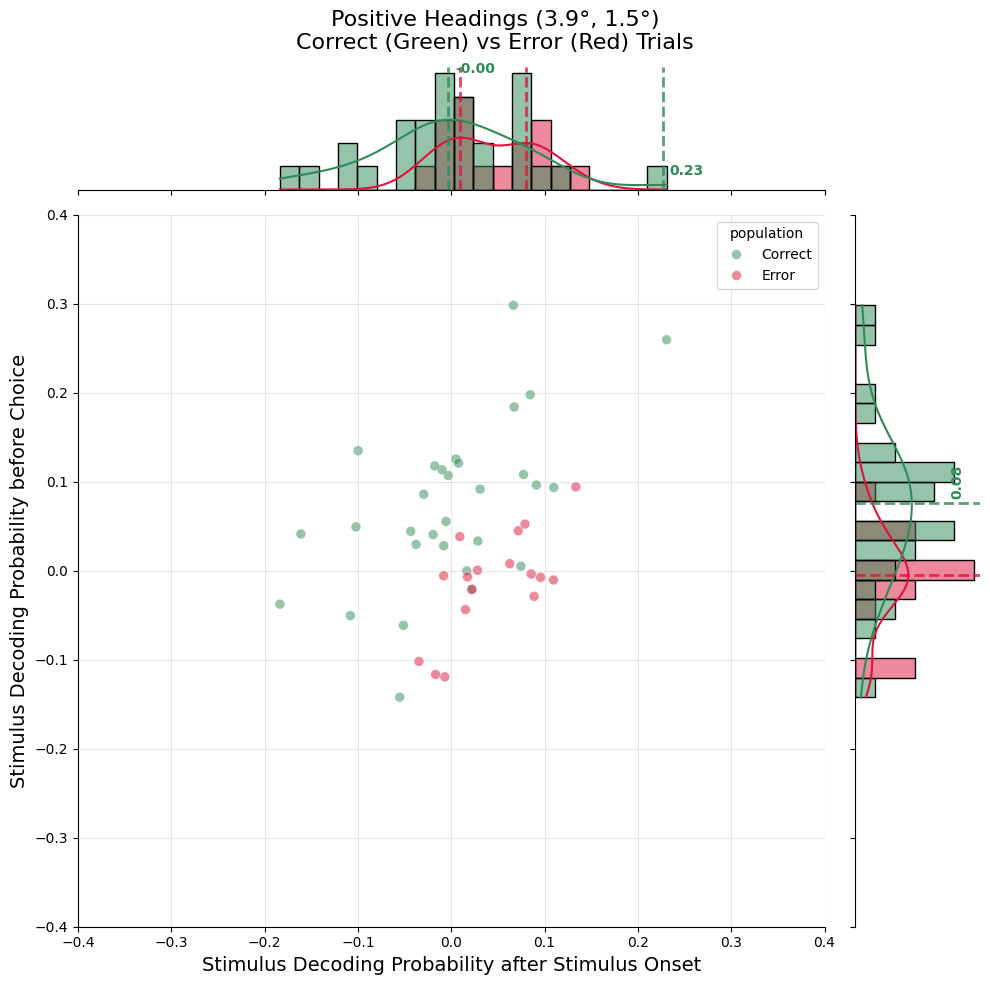


Creating Figure 2: Negative Headings

STATISTICAL COMPARISONS BETWEEN POPULATIONS

X Dimension (Stimulus Decoding Probability after Stimulus Onset):
------------------------------
Correct: mean=0.012, std=0.076, n=37
Error: mean=0.032, std=0.029, n=10
T-test: t=-0.828, p=0.412
Mann-Whitney U: U=140.0, p=0.247
KS test: D=0.459, p=0.048

Y Dimension (Stimulus Decoding Probability before Choice):
------------------------------
Correct: mean=-0.057, std=0.115, n=37
Error: mean=0.028, std=0.086, n=10
T-test: t=-2.121, p=0.039
Mann-Whitney U: U=106.0, p=0.041
KS test: D=0.441, p=0.066

Interpretation (α = 0.05):
------------------------------
X dimension: Not significantly different
Y dimension: Significantly different

CORRELATION STATISTICS
Overall: r = 0.356, p = 0.014
Correct: r = 0.325, p = 0.050
Error: r = 0.558, p = 0.094


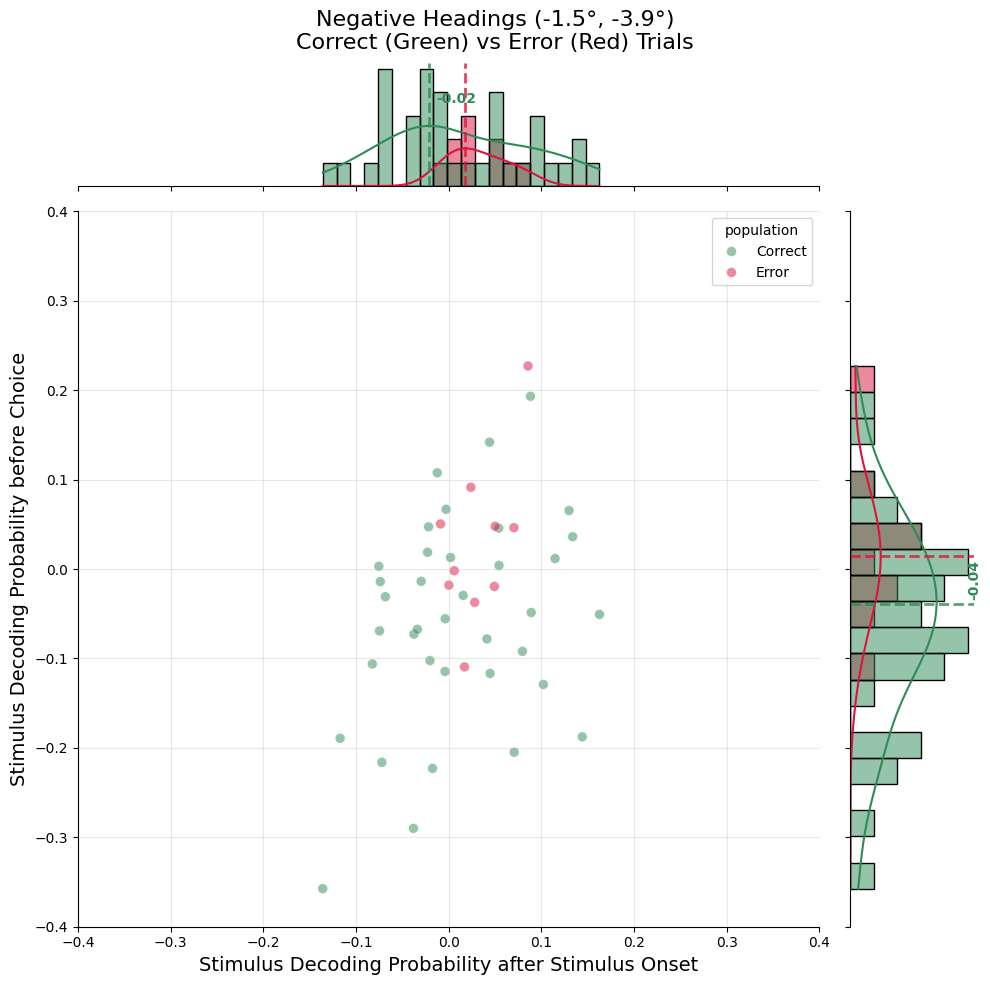


=== SUMMARY STATISTICS ===
Positive headings: 30 correct, 17 error trials
Negative headings: 37 correct, 10 error trials
Total: 67 correct, 27 error trials


In [ ]:


# Define the heading groups
positive_headings = [ '1.5°']  # Positive angles
negative_headings = ['-1.5°']  # Negative angles
# positive_headings = ['1.5°']  # Positive angles
# negative_headings = ['-1.5°']  # Negative angles


# Collect data for positive headings
print("Processing positive headings...")
positive_trials = []
for heading in positive_headings:
    if heading in scatter_data:
        positive_trials.extend(scatter_data[heading])

pos_correct = [t for t in positive_trials if t['correct'] == 1.0]
pos_error = [t for t in positive_trials if t['correct'] == 0.0]

print(f"Positive headings: {len(pos_correct)} correct, {len(pos_error)} error trials")

# Collect data for negative headings
print("Processing negative headings...")
negative_trials = []
for heading in negative_headings:
    if heading in scatter_data:
        negative_trials.extend(scatter_data[heading])

neg_correct = [t for t in negative_trials if t['correct'] == 1.0]
neg_error = [t for t in negative_trials if t['correct'] == 0.0]

print(f"Negative headings: {len(neg_correct)} correct, {len(neg_error)} error trials")

# FIGURE 1: Positive headings
if len(pos_correct) > 0 and len(pos_error) > 0:
    print("\nCreating Figure 1: Positive Headings")
    
    # Extract probabilities for positive headings
    pos_correct_stim = [t['y_proba_stimulus_norm'] for t in pos_correct]
    pos_correct_choice = [t['y_proba_choice_norm'] for t in pos_correct]
    pos_error_stim = [t['y_proba_stimulus_norm'] for t in pos_error]
    pos_error_choice = [t['y_proba_choice_norm'] for t in pos_error]
    
    g1 = plot_2d_scatter_with_marginals(
        pos_correct_stim, pos_correct_choice,    # Population 1: Correct trials
        pos_error_stim, pos_error_choice,        # Population 2: Error trials
        xlabel='Stimulus Decoding Probability after Stimulus Onset',
        ylabel='Stimulus Decoding Probability before Choice',
        title='Positive Headings (3.9°, 1.5°)\nCorrect (Green) vs Error (Red) Trials',
        legend_labels=['Correct', 'Error'],
        colors=['#2E8B57', '#DC143C'],  # Green for correct, Red for error
        figsize=(10, 10),
        alpha=0.5,
        point_size=50,
        show_correlation=True,
        kde=True
    )
    
    plt.show()

# FIGURE 2: Negative headings  
if len(neg_correct) > 0 and len(neg_error) > 0:
    print("\nCreating Figure 2: Negative Headings")
    
    # Extract probabilities for negative headings
    neg_correct_stim = [t['y_proba_stimulus_norm'] for t in neg_correct]
    neg_correct_choice = [t['y_proba_choice_norm'] for t in neg_correct]
    neg_error_stim = [t['y_proba_stimulus_norm'] for t in neg_error]
    neg_error_choice = [t['y_proba_choice_norm'] for t in neg_error]
    
    g2 = plot_2d_scatter_with_marginals(
        neg_correct_stim, neg_correct_choice,    # Population 1: Correct trials
        neg_error_stim, neg_error_choice,        # Population 2: Error trials
        xlabel='Stimulus Decoding Probability after Stimulus Onset',
        ylabel='Stimulus Decoding Probability before Choice',
        title='Negative Headings (-1.5°, -3.9°)\nCorrect (Green) vs Error (Red) Trials',
        legend_labels=['Correct', 'Error'],
        colors=['#2E8B57', '#DC143C'],  # Green for correct, Red for error
        figsize=(10, 10),
        alpha=0.5,
        point_size=50,
        show_correlation=True,
        kde=True
    )
    
    plt.show()

# Print summary statistics
print(f"\n=== SUMMARY STATISTICS ===")
print(f"Positive headings: {len(pos_correct)} correct, {len(pos_error)} error trials")
print(f"Negative headings: {len(neg_correct)} correct, {len(neg_error)} error trials")
print(f"Total: {len(pos_correct) + len(neg_correct)} correct, {len(pos_error) + len(neg_error)} error trials")